In [1]:
import numpy as np
from numpy.random import default_rng

rng = np.random.default_rng()     # common random number generator

# Assignment 2: $k$-Fold Cross-Validation

Implement a function that compares two learning algorithms using $k$-fold 
cross-validation. A target function is 
$f: \mathrm{R}^n \to \{0,1\}$, where $\mathrm{R}$ is the set of real numbers. The goal of a learning
algorithm is to identify a function $h: \mathrm{R}^n \to \{0,1\}$, called
hypothesis, from some class of functions $\mathcal{H}$ such that the
function $h$ is a good approximation of the target function $f$. The
only information the algorithm can use is a sample $S\subset X$ called
a training set, and the correct value $f(x)$, called label, for all $x \in S$.
The sample $S$ is a set of $n$ elements from $X$ randomly selected
according to some probabilistic distribution $D$.

Suppose that each learning algorithm is implemented as two functions `learn()` and `apply()`:
```
def learn(X, y, par):
    ...
    return learned_par
```
where

Param  |Meaning
------ |---------------------------------------------------------------
`learn`|is the name of the learning function,
`X`    |is a two-dimensional numpy array (X_traing vectors are the rows of `X`),
`y`    |is a vector of desired outputs (0/1), and
`par`  |is a variable containing parameters of the learning algorithm.

Such function returns learned parameters in the variable `learned_par`.

Further, we will need a function

```
def apply(learned_par, X):
    ...
    return out
```
where

Param  |Meaning
------ |---------------------------------------------------------------
`learned_par`|is a variable with the parameters learned by the function `learn`,
`X`    |is a two-dimensional numpy array (X_traing vectors are the rows of `X`),


that computes the learned function with parameters `learned_par` on input
vectors from a two-dimensional numpy array `X` (each row of the array is an input
vector). The returned value `out` is a vector of the results - zeros and ones.

Then it is possible to implement the following function.

In [2]:
def err(name_learn: str, name_apply: str, par: object, 
        X_train: np.ndarray, y_train: np.ndarray, 
        X_test: np.ndarray, y_test: np.ndarray,
        *, safe=False) -> float:
    '''Trains the algorithm name_learn with parameters par
    on the train set X_train with the true labels y_train. Then,
    it compares predictions computed by the trained function on the test set
    X_test with the true labels y_test.
    It returns the error rate on the test set.
    
        error_rate = err(name_learn, name_apply, par, X_train, y_train, X_test, y_test)
        
    Args:
        name_learn: The name of the training algorithm.
        name_apply: The name of the function for applying the learned function.
        par: The parameters of the learning algorithm.
        X_train (2-d numpy array of floats): The training set; samples are rows.
        y_train (vector of integers 0/1): The true labels for the training samples.
        X_test (2-d numpy array of floats): The test set; samples are rows.
        y_test (vector of integers 0/1): The true labels for the test samples.
        
    Returns:
        error_rate: The error rate (a float between 0.0 and 1.0) of the function 
            with the name trained_apply on the test set X_test with correct 
            labels y_test after training using the function with the name
            name_learned with parameters par on the train set X_train with the correct
            labels y_train.
    '''
    if safe:
        # copy for safety (bad function could modify data)
        X_train, y_train, X_test = X_train.copy(), y_train.copy(), X_test.copy()
    
    learned_par = eval(name_learn+"(X_train, y_train, par)")
    out = np.array(eval(name_apply+"(learned_par, X_test)"))
    return (out != y_test).mean()

that computes the error of the function `name_learned` learned by the
algorithm `name_apply` with parameters `par` on a training set `X_train` and
desired outputs `y_train`. The error is computed on a test set `X_test` with the
desired outputs `y_test`. Note that the result of the function `err` is
always a real value from the closed interval $\langle0;1\rangle$, **not
the number of errors** made by the learned algorithm on the test set.
`name_learn` and `name_learned` are strings containing the names of the respective
functions. The respective functions can be evaluated using Python's function
`eval`, as shown below.

In [3]:
import math

fun = "math.log"
a = 16
b = 2
eval(fun+"(a, b)")

4.0

Then it is easy to implement the following function

In [4]:
def cross_val(name_learn1: str, name_apply1: str, par1: object, 
              name_learn2: str, name_apply2: str, par2: object, 
              X: np.ndarray, y: np.ndarray, k: int, shuffle: bool = True) -> (float, float):
    '''Computes the difference between errors and the standard deviation of the difference for
    two learning algorithms.
    
        delta, std = cross_val(name_learn1, name_apply1, par1, 
                               name_learn2, name_apply2, par2, 
                               X, y, k, shuffle)
                               
    Args:
        name_learn1: The name of the first training algorithm.
        name_apply1: The name of the function for applying the first learned function.
        par1: The parameters of the first learning algorithm.
        name_learn2: The name of the second training algorithm.
        name_apply2: The name of the function for applying the second learned function.
        par2: The parameters of the second learning algorithm.
        X (2-d numpy array of floats): The training set; samples are rows.
        y (vector of integers 0/1): The desired outputs for the training samples.
        k: The number of folds used in k-fold cross-validation.
        shuffle: If True, shuffle the samples into folds; otherwise, do not shuffle
                 the samples before splitting them into folds.
    
    Returns:
        delta: The estimated difference: error rate of the first algorithm minus 
            the error rate of the second algorithm computed using k-fold cross-validation.
        std: The standard deviation of the estimated difference of errors.            
    '''
    # Main idea is I don't want to copy arrays so I swap test and train samples
    assert X.shape[0] == y.shape[0]
    assert k > 1

    sample_count, _ = X.shape

    # calculates lengths of the splits
    # there will be k splits of the same length
    # or there will be sample_count % k splits of length l and k - sample_counts % k splits of length l - 1
    test_len = sample_count // k
    count = k - sample_count % k  # count of the all or shorter splits

    if test_len < 30:
        # just a warning to std.out, in practice better logging should be created
        print(f"Warning: too little samples ({sample_count}) for k={k}, should be at least {k*30}.")
    
    if shuffle:
        perm = rng.permutation(sample_count)
    else:
        perm = np.arange(sample_count)

    # Note: starting splitting from the back for better interchange between short and long splits
    # i.e. 
    X_test = X[perm[-test_len:]]
    y_test = y[perm[-test_len:]]
    X_swap = np.empty_like(X_test)
    y_swap = np.empty_like(y_test)
    X_train = X[perm[:-test_len]]
    y_train = y[perm[:-test_len:]]

    ds = np.empty(k)

    split_i = k - 1
    # already swapped train-test from this index in X_train
    done_from = sample_count - test_len  # == len(X_train)

    def process_split():
        nonlocal split_i
        # adds error of first alg for current split - error of the second alg
        ds[split_i] = (
            err(name_learn1, name_apply1, par1, X_train, y_train, X_test, y_test) 
            -
            err(name_learn2, name_apply2, par2, X_train, y_train, X_test, y_test)
        )
        split_i -= 1
    
    def swap_splits():
        nonlocal done_from
        # swap test array with first samples not used as test
        # only test_samples are moved/copied
        X_swap[:] = X_train[done_from-test_len:done_from]
        X_train[done_from-test_len:done_from] = X_test
        X_test[:] = X_swap

        y_swap[:] = y_train[done_from-test_len:done_from]
        y_train[done_from-test_len:done_from] = y_test
        y_test[:] = y_swap

        done_from -= test_len

    # cycle splits
    process_split()
    for _ in range(count - 1):
        swap_splits()
        process_split()

    if count < k:
        # uneven splits - start processing longer now

        # reformat splits (row done_from-test_len-1 is "deleted" from train set)
        X_swap = X_train[done_from-test_len-1:done_from].copy()
        X_train = np.vstack((               # 2d and/or 1d arrays
            X_train[:done_from-test_len-1], # not yet processed tests (new test in X_swap excluded)
            X_test,                         # previous test split
            X_train[done_from:]             # already processed tests
        ))
        X_test = X_swap.copy()

        y_swap = y_train[done_from-test_len-1:done_from].copy()
        y_train = np.concatenate((          # 1d arrays
            y_train[:done_from-test_len-1], # not yet processed tests (new test in y_swap excluded)
            y_test,                         # previous test split
            y_train[done_from:]             # already processed tests
        ))
        y_test = y_swap.copy()

        done_from -= test_len + 1

        # calculate new split parameters
        test_len += 1
        count = k - count

        # cycle remaining splits
        process_split()
        for _ in range(count - 1):
            swap_splits()
            process_split()
    
    mean = ds.mean()
    # formula from moodle not `np.std(ds, ddof=1)` where we divide by k-1 not by k*(k-1)
    std = np.sqrt(((a - mean) ** 2).sum() / (k*(k-1)))
    # std = np.std(ds, ddof=1)
    return mean, std

that estimates the difference between the errors of the hypothesis
`name_learned1` learned by a learning algorithm `name_learn1` with parameters `par1`
and the error of the hypotheses `name_learned2` learned by a learning algorithm
`name_learn2` with parameters `par2` using `k`-fold cross-validation on
patterns `X` with the desired outputs `y`. The function returns the estimated
difference of errors `delta` and estimated standard deviation `s` of this
estimator. **You should implement your own function using `numpy`, not use 
any implementation of cross-validation from any third-party library!**

If the value of `shuffle` is `False`, then
the order of samples must not be changed before partitioning into folds
for `k`-fold cross-validation, and all folds should be continuous parts
of `X`. If the value of `shuffle` is `True`, then the patterns from `X` 
should be assigned randomly into `k` folds.

*Note: The sizes of the folds can differ by at most 1.* 

For example, we can compare the errors of the perceptron learning
algorithm limited to at most 10 epochs and the perceptron learning
algorithm limited to at most 100 epochs. As the perceptron learning
algorithm, we will use the function `perc_learn` obtained using our implementation 
of class `Perceptron` from the lab. Similarly, for applying the learned perceptron
we will use `perc_apply` given below. For that, prepare a Python module `Perceptron` with the implementation of the class `Perceptron` from the previous lab. 

In [5]:
from Perceptron import Perceptron

def perc_learn(X: np.ndarray, y: np.ndarray, par: list) -> Perceptron:
    '''Train perceptron
    
        perc = perc_learn(X, y, par)
        
    Args:
        X (2-d numpy array of floats): The training set; samples are rows.
        y (vector of integers 0/1): The desired outputs for the training samples.
        par: List of the parameters for the perceptron learning algorithm
             [w, lr, max_epochs]:
                 w (nd.array): The extended weight vector of a perceptron.
                 lr (float): The learning rate of the perceptron.
                 max_epochs (int): The maximal number of learning epochs.
    
    Returns:
        perc (Perceptron): Trianed perceptron
    '''
    perc = Perceptron(init_weights=par[0])
    perc.fit(X,y, lr=par[1], max_epochs=par[2])
    return perc

def perc_apply(learned_par: Perceptron, X: np.ndarray) -> np.ndarray:
    '''Apply learned perceptron on inputs X.
    
        predictions = perc_apply(learned_par, X)
        
    Args:
        learned_par (Perceptron): An instance of the class Perceptron.
        X (2-d numpy array of floats): The training set; samples are rows.
        
    Returns:
        predictions (vector of 0/1): predictions of the perceptron learned_par 
                                     on the test set X.
    '''
    Out = learned_par.predict(X)
    return Out

Another learning algorithm we will implement is `memorizer`, which
memorizes all training samples and their true labels. Learned `memorizer` answers correctly on the inputs from the
training set and randomly otherwise:

In [6]:
def memorizer_learn(X: np.ndarray, y: np.ndarray, par: object = None) -> list:
    '''The learning algorithm that only remembers all training
    samples and the desired answers for them.

        learned_par = memorizer_learn(X, y, par)
    
    Args:
        X (2-d numpy array of floats): The training set; samples are rows.
        y (vector of integers 0/1): The desired outputs for samples from X.
        par: It is not used here, it is present here for compatibility only
    
    Returns:
        learned_par (list): The list containing the training samples and
            the desired outputs for them.
    '''
    return [X, y]

def memorizer_apply(learned_par: list, X: np.ndarray):
    '''A function simulating Memorizer
    
         out = memorizer_apply(learned_par, X)
    
    Args:
        learned_par (list): List with training samples and the respective desired outputs.
        X (2-d numpy array of floats): The test set; samples are rows.
    
    Returns:
        out (vector of floats): whenever the i-th input vector is contained 
            within the memorized input samples, out[i] equals the i-th 
            remembered desired output, otherwise it will be randomly 0 or 1
    '''
    known = learned_par[0]
    known_out = learned_par[1]
    # generate random outputs
    out = rng.integers(0, 2, size=X.shape[0])    
    for i in range(X.shape[0]):
        for j in range(known.shape[0]):
            if np.array_equal(X[i], known[j,:]):
                out[i] = known_out[i]
                break
    return out

When applying $k$-fold cross-validation, we will compute the confidence interval for the estimation of the difference of errors computed by the `cross_val()` function. Implement the following function.

In [7]:
from scipy.stats import t

def conf_interval(d: float, s: float, conf_level: float, k: int) -> tuple:
    '''Compute confidence interval for the estimated difference of errors d 
    with standard deviation s returned from cross_val.
    
        low, high = conf_inteval(d, s, conf_level, k)
    
    Args:
        d: The difference of errors computed by k-fold cross-validation.
        s: The standard deviation of the difference of errors computed 
            by k-fold cross-validation.
        conf_level: percents
    '''
    z = t.ppf((100+conf_level)/200, k-1)
    dif = z * s
    return d - dif, d + dif

The above algorithms can be compared using the above function
`cross_val`.

In [8]:
# at first we read training patterns; 
# this should be a matrix of size 600 x 2
X1 = np.genfromtxt('X1.csv', delimiter=',', dtype = float)
print(X1)
print(X1.shape)

# then we read the desired outputs for the X_traing patterns 
# (0/1 vector of length 600)
y1 = np.genfromtxt('y1.csv', delimiter=',', dtype = int)
print(y1)

# a row X1[i] is the i-th training vector with 
# the desired output y1[i].

# we prepare two lists of the learning parameters
# for the perceptron learning algorithm consisting of:
#     an extended weight vector,
#     a learning rate, and
#     a maximal number of epochs
par1 = [[1, 1, -1], 1, 10]
par2 = [[1, 1, -1], 1, 200]

# run 5-fold cross-validation
k = 5
d, s = cross_val('perc_learn', 'perc_apply', par1, 'perc_learn', 'perc_apply',
                par2, X1, y1, k, shuffle=False)

print(f"Estimated error difference {d}, standard deviation for the estimate is {s}")
# print the interval to which the true error difference belongs 
# with probability at least 95%
print(f"Confidence interval {conf_interval(d, s, 95, k)}")


[[-2.7272648  -3.61613625]
 [ 3.31729307  2.77077998]
 [ 4.74161526  3.35034658]
 ...
 [ 1.71882423 -1.07303966]
 [ 2.24315112 -0.69097537]
 [ 2.77739445  0.27689117]]
(600, 2)
[0 1 1 0 0 1 0 0 1 0 0 1 1 1 0 1 1 1 0 1 0 0 1 1 1 1 0 0 1 1 0 0 0 1 0 1 0
 1 0 1 0 0 1 1 1 1 0 1 1 1 1 0 1 1 0 1 0 1 1 1 0 1 1 0 0 1 0 0 1 1 0 0 0 1
 1 0 0 0 0 0 1 0 0 1 1 1 0 0 0 1 1 0 1 0 0 1 0 0 0 0 0 1 0 0 1 1 1 0 1 0 1
 1 0 0 1 1 0 1 0 1 0 1 0 1 0 0 0 1 1 1 1 0 0 1 1 1 0 0 0 1 1 1 0 1 0 0 0 1
 0 1 1 0 1 1 0 0 1 0 1 1 1 1 0 1 1 1 1 0 0 0 1 1 0 1 0 0 0 0 0 1 0 0 0 1 1
 1 1 1 0 1 0 1 0 0 0 0 1 1 1 0 1 0 0 1 0 1 0 1 0 1 1 0 1 1 1 1 0 0 1 0 1 1
 0 0 1 1 0 1 1 1 0 1 0 1 0 1 1 0 0 1 1 1 1 1 1 0 0 0 1 1 1 1 0 0 0 0 0 0 1
 1 1 1 0 1 0 1 1 1 0 1 0 0 1 0 0 1 0 1 1 0 1 1 0 0 1 0 0 1 1 1 1 0 0 0 0 1
 0 0 1 0 1 0 1 1 0 1 1 1 1 0 1 0 1 1 1 1 1 1 0 0 0 0 0 1 0 0 0 1 0 0 1 1 0
 1 0 1 1 1 1 1 1 1 0 0 1 0 1 1 1 0 1 1 1 1 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 1
 0 0 0 0 1 0 0 1 0 0 0 1 1 0 0 0 1 1 0 0 0 1 0 1 0 1 1 1 0 1 0 1 1 0 0 0 

**Results with `np.std(deltas, ddof=1)`:**  
Estimated error difference -0.026666666666666665, standard deviation for the estimate is 0.05116693811002917  
Confidence interval (-0.16872886153021585, 0.11539552819688251)

**Another run with shuffle**:

In [19]:
dd, ss = cross_val('perc_learn', 'perc_apply', par1, 'perc_learn', 'perc_apply',
                par2, X1, y1, k, shuffle=True)

print(f"Estimated error difference {dd}, standard deviation for the estimate is {ss}")
# print the interval to which the true error difference belongs 
# with probability at least 95%
print(f"Confidence interval {conf_interval(dd, ss, 95, k)}")

Estimated error difference 0.05833333333333334, standard deviation for the estimate is 2.9105368125205078
Confidence interval (-7.423439731730443, 7.54010639839711)


**Tasks:**

1.  Implement the functions `err`, `cross_val`, `conf_interval`, and by running the above     script,
    estimate the difference in error rates of the perceptron learning
    algorithm with at most 10 epochs and of the same perceptron learning
    algorithm with at most 200 epochs. From the resulting error
    difference and the standard deviation of the estimate, compute the
    interval which contains the true error difference with the
    probability of 95%. Is the error difference statistically significant?

2.  Then modify the above script to compare error rates of the algorithm
    memorizer and perceptron with at most 50 epochs, learning rate 1.0,
    and initial extended weight vector `[1, 1, 1, 1, -1]` using 6-fold
    cross-validation on the following 600 samples:

In [9]:
# samples
X2 = np.genfromtxt('X2.csv', delimiter=',', dtype = float)

# labels for the samples
y2 = np.genfromtxt('y2.csv', delimiter=',', dtype = int)

# in order to obtain the same answers from memorizer_apply, we reset random 
# numbers generator before calling cross_val
rng = default_rng(seed=1)

par = [[1, 1, 1, 1, -1], 1, 50]

k = 6
d, s = cross_val('perc_learn', 'perc_apply', par, 'memorizer_learn', 'memorizer_apply',
                None, X2, y2, k, shuffle=False)

print(f"Estimated error difference {d}, standard deviation for the estimate is {s}")
# print the interval to which the true error difference belongs 
# with probability at least 95%
print(f"Confidence interval {conf_interval(d, s, 95, k)}")


Estimated error difference -0.445, standard deviation for the estimate is 3.0024324860574856
Confidence interval (-8.16299841432141, 7.2729984143214095)


<span id=np></span>
**Results with `np.std(deltas, ddof=1)`:**  
Estimated error difference -0.445, standard deviation for the estimate is 0.07529940238806683  
Confidence interval (-0.6385632760867092, -0.25143672391329086)

**You should submit** a Jupyter notebook with 

* commented **source code** of the functions `err`, `cross_val`, `conf_interval`, and
  all the functions you have used for solving the above tasks. Do not forget to attach your implementation of the class `Perceptron`.

* The notebook should contain **the results** of your experiments for both above tasks. You should analyze
  the obtained results, **answer the question** on the significance in both tasks. 
  
* Write **a recommendation** which
  algorithm is better to use. Eventually, you can advise which
  experiments would be suitable for a more thorough comparison of the
  considered learning algorithms.

In [10]:
import matplotlib.pyplot as plt

def plot(X, y):
    plt.plot(X[y == 1, 0],X[y == 1, 1],'+r',label='Positive')
    plt.plot(X[y == 0, 0],X[y == 0, 1],'xb', label='Negative')
    xr = np.array([X[:,0].min(),X[:,1].max()])
    plt.legend()

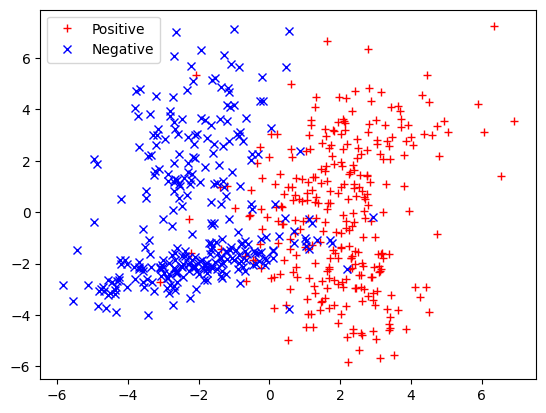

In [11]:
plot(X1, y1)

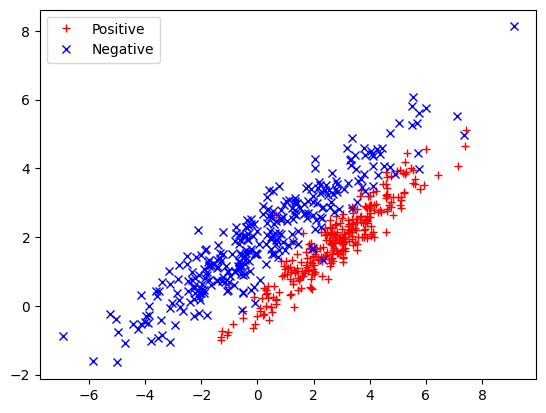

In [12]:
plot(X2, y2)

## Conclusion

### Standard deviation
First of all, I am not really sure about the estimate of standard deviation. In the solution, one from *TestLearningAlg* notebook is used, which uses following formula:
$$s_{\overline{\delta}} = \sqrt{\frac{1}{k(k-1)} \sum_{i=1}^{k} (\delta_i - \overline{\delta})^2}$$
But `np.std(..., ddof=1)` uses
$$s_{\overline{\delta}} = \sqrt{\frac{1}{k-1} \sum_{i=1}^{k} (\delta_i - \overline{\delta})^2}$$

The second one results in much smaller standard deviation from which follows much narrower confidence interval that implies statistical significance. Results with np.std function are also included and shows that perceptron can be reliably better than memorizer, which would make sense, so I am confused a little.  

On the other hand when I used presented function from moodle notebook it results into confidence interval that does not provide any useful information.

### Answers
When comparing perceptrons with different numbers of learning epochs, neither formula shows significant error difference, but when np.std is used, perceptron is significantly better than memorizer see [above](#np).

### Experiments
I visually verified that presented data are "quite" linearly separable.

It surprises me that perceptron with less learning epochs has better results, but since data are not "fully" linearly separable it could be just luck with a "good" splits, that was verified by another run of `cross_val` with `shuffle=True` (see above). That correspond to large insignificant confidence interval.

### Recommendation
Perceptron is much better since it is more flexible - it can respond well even for similar samples, it is not so much demanding (memory-wise) for big datasets and it is much faster (but memorizer could be upgraded with some kind of faster lookup e.g. hashing).

For better comparison it would be suitable to use more learning epochs and "fully" linearly separable data, or at least data with more outlying clusters.

